# Homework 2: Trees and Calibration


## Instructions

Please push the .ipynb, .py, and .pdf to Github Classroom prior to the deadline. Please include your UNI as well.

**Make sure to use the dataset that we provide in CourseWorks/Classroom.**

**There are a lot of applied questions based on the code results. Please make sure to answer them all. These are primarily to test your understanding of the results your code generate (similar to any Data Science/ML case study interviews).**



```
# This is formatted as code
```

## Name: Jason Jin

## UNI: hj2602

## The Dataset


### Description

This data set contains details of ecommerce product shipment tracking and the target variable is a binary variable reflecting the fact whether the product reached on time or not.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Question 1: Decision Trees

**1.1: Load the provided dataset**

In [3]:
## YOUR CODE HERE
df = pd.read_csv("data.csv")
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached_On_Time
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


**1.2: Are there any missing values in the dataset?**

In [6]:
## YOUR CODE HERE
print(df.isnull().values.any())

False


**1.3: Plot side-by-side bars of class distribtuion for each category for the categorical feature and the target categories.**


In [7]:
## YOUR CODE HERE
df.dtypes

ID                      int64
Warehouse_block        object
Mode_of_Shipment       object
Customer_care_calls     int64
Customer_rating         int64
Cost_of_the_Product     int64
Prior_purchases         int64
Product_importance     object
Gender                 object
Discount_offered        int64
Weight_in_gms           int64
Reached_On_Time         int64
dtype: object

In [8]:
df_cat = df.select_dtypes(include=['object'])
df_cat

,Warehouse_block,Mode_of_Shipment,Product_importance,Gender
0,D,Flight,low,F
1,F,Flight,low,M
2,A,Flight,low,M
3,B,Flight,medium,M
4,C,Flight,medium,F
...,...,...,...,...
10994,A,Ship,medium,F
10995,B,Ship,medium,F
10996,C,Ship,low,F
10997,F,Ship,medium,M


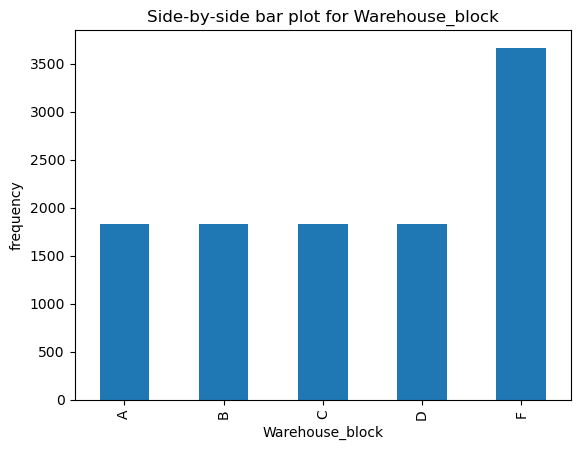

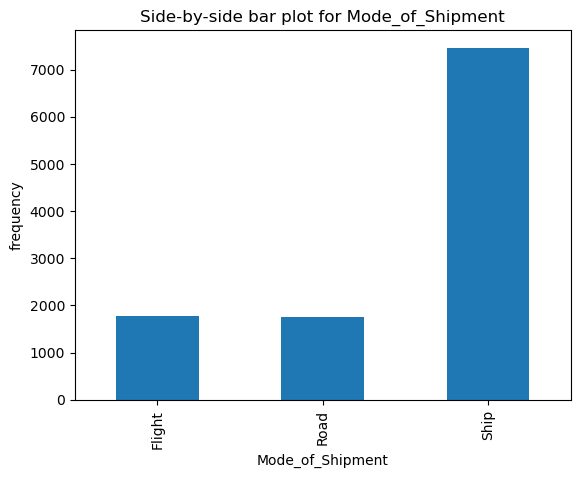

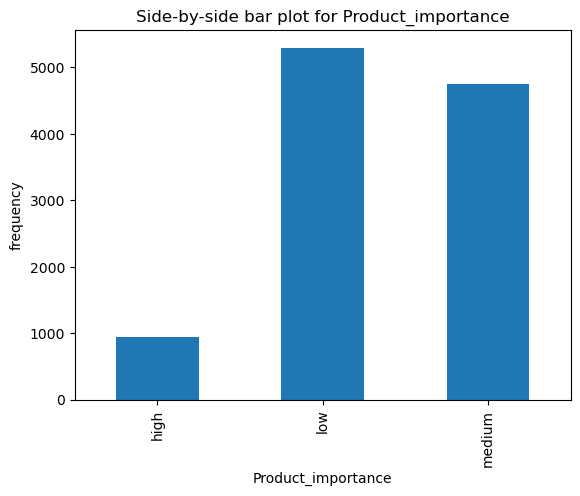

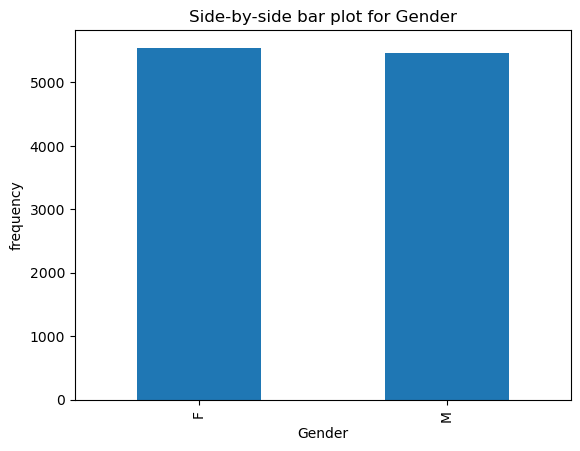

In [9]:
plt.figure()
cat_column_list = list(df_cat.columns)
for column in cat_column_list:
    df_cat[column].value_counts().sort_index().plot(kind='bar', xlabel=column, ylabel='frequency', title='Side-by-side bar plot for %s'%column)
    plt.show()

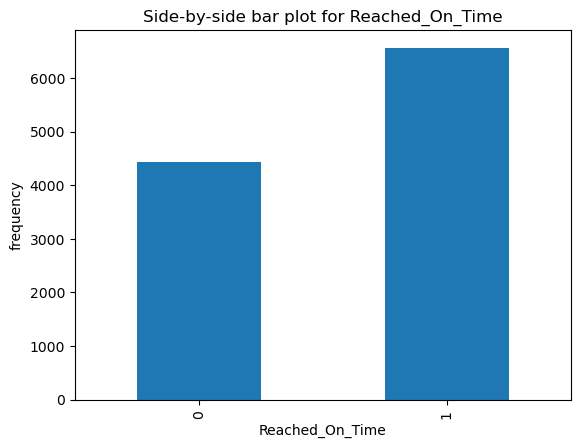

In [10]:
plt.figure()
df['Reached_On_Time'].value_counts().sort_index().plot(kind='bar', xlabel='Reached_On_Time', ylabel='frequency', title='Side-by-side bar plot for Reached_On_Time')
plt.show()

**1.4: Explain the distribution of the target variable and the dataset.**


In [11]:
## YOUR CODE HERE
df['Reached_On_Time'].value_counts()

1    6563
0    4436
Name: Reached_On_Time, dtype: int64

In [12]:
df['Reached_On_Time'].value_counts(normalize=True)

1    0.596691
0    0.403309
Name: Reached_On_Time, dtype: float64

There is roughly 6:4 ratio of products that reached on time and products that did not reach on time. There is somewhat imbalance as within the dataset 60% has reached on time and the rest 40% has not reached on time. 

**1.5: Split the data into development and test datasets. Which splitting methodology did you choose and why?**

**Hint: Based on the distribution of the data, try to use the best splitting strategy.**

In [16]:
df.dtypes

ID                      int64
Warehouse_block        object
Mode_of_Shipment       object
Customer_care_calls     int64
Customer_rating         int64
Cost_of_the_Product     int64
Prior_purchases         int64
Product_importance     object
Gender                 object
Discount_offered        int64
Weight_in_gms           int64
Reached_On_Time         int64
dtype: object

In [15]:
num_features = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']
ohe_features = ['Warehouse_block', 'Mode_of_Shipment', 'Gender']
te_features = ['Product_importance']

In [12]:
#encoded_cat_df = pd.get_dummies(df[ohe_features + te_features])
#encoded_df = pd.concat([encoded_cat_df, df[num_features]], axis=1)

In [17]:
## YOUR CODE HERE
from sklearn.model_selection import train_test_split
X_dev, X_test, y_dev, y_test = train_test_split(df[te_features+ohe_features+num_features], df['Reached_On_Time'], test_size=0.2, stratify=df['Reached_On_Time'], random_state=42)

Here we can use the stratifying splitting methodology as the dataset is imbalanced. We want to also have the development set and test set in good balance that represents the orginal data so the stratifying method is optimal.

**1.6: Would you drop any column? Justify your reasoning.** 

**Preprocess the data (Handle the Categorical Variable). Do we need to apply scaling? Briefly Justify**



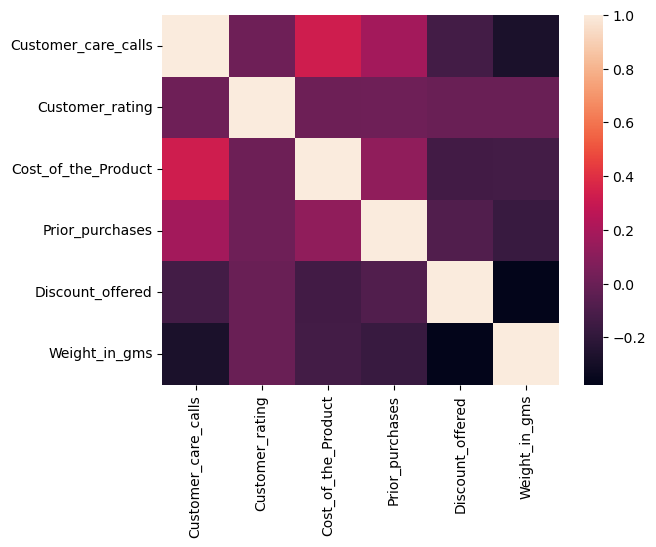

In [18]:
corr_matrix = df[num_features+ohe_features+te_features].corr()
plt.figure()
sns.heatmap(corr_matrix)
plt.show()

We don't want to drop any columns as the features do not have much correlation to each other. And yes we have to apply scaling for the categorical variables and the numerical variables as below.

In [19]:
## YOUR CODE HERE
#pip install category_encoders
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import TargetEncoder
preprocess = make_column_transformer((StandardScaler(), num_features),
                                     (OneHotEncoder(handle_unknown='ignore'), ohe_features),
                                     (TargetEncoder(handle_unknown='ignore'), te_features), 
                                     remainder='passthrough')

**1.7: Fit a Decision Tree on the development data until all leaves are pure. What is the performance of the tree on the development set and test set? Evaluate test and train accuarcy on F-1 score and accuracy.**

In [21]:
## YOUR CODE HERE
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
dtc = DecisionTreeClassifier(random_state=0)
pipe = make_pipeline(preprocess, GridSearchCV(dtc,
                                             param_grid={},
                                             return_train_score=True))

pipe.fit(X_dev, y_dev)
grid_search_results = pipe.named_steps['gridsearchcv']
print(f"Best train score: ", grid_search_results.best_score_) 
print(f"Best train alpha: ", grid_search_results.best_params_) 
print(f"Test score:", pipe.score(X_test, y_test)) 

Best train score:  0.6522334487570417
Best train alpha:  {}
Test score: 0.644090909090909


In [22]:
from sklearn.metrics import accuracy_score, f1_score

y_pred = pipe.predict(X_test)
print(f"Test accuracy: ", accuracy_score(y_test, y_pred))
print(f"Test f-1 score: ", f1_score(y_test, y_pred))

Test accuracy:  0.644090909090909
Test f-1 score:  0.7072897196261682


/Users/jasonjin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/jasonjin/opt/anaconda3/lib/python3.9/site-packages/category_encoders/utils.py:360: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


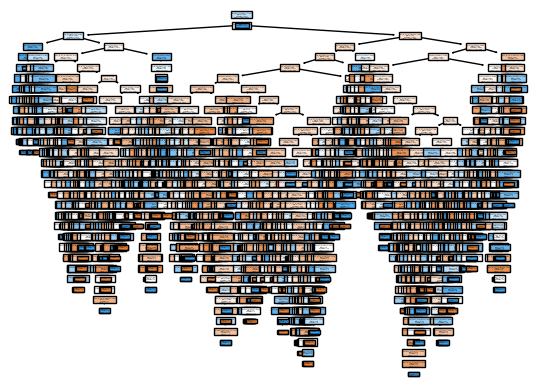

In [23]:
## YOUR CODE HERE
best_tree = grid_search_results.best_estimator_
ohe_feature_names = preprocess.named_transformers_['onehotencoder'].get_feature_names()
te_feature_names = preprocess.named_transformers_['targetencoder'].get_feature_names()
feature_names = num_features + ohe_feature_names.tolist() + te_feature_names
visual_tree = plot_tree(best_tree, feature_names=feature_names, filled=True)
plt.show()

**1.8: Visualize the trained tree until the max_depth 8.**

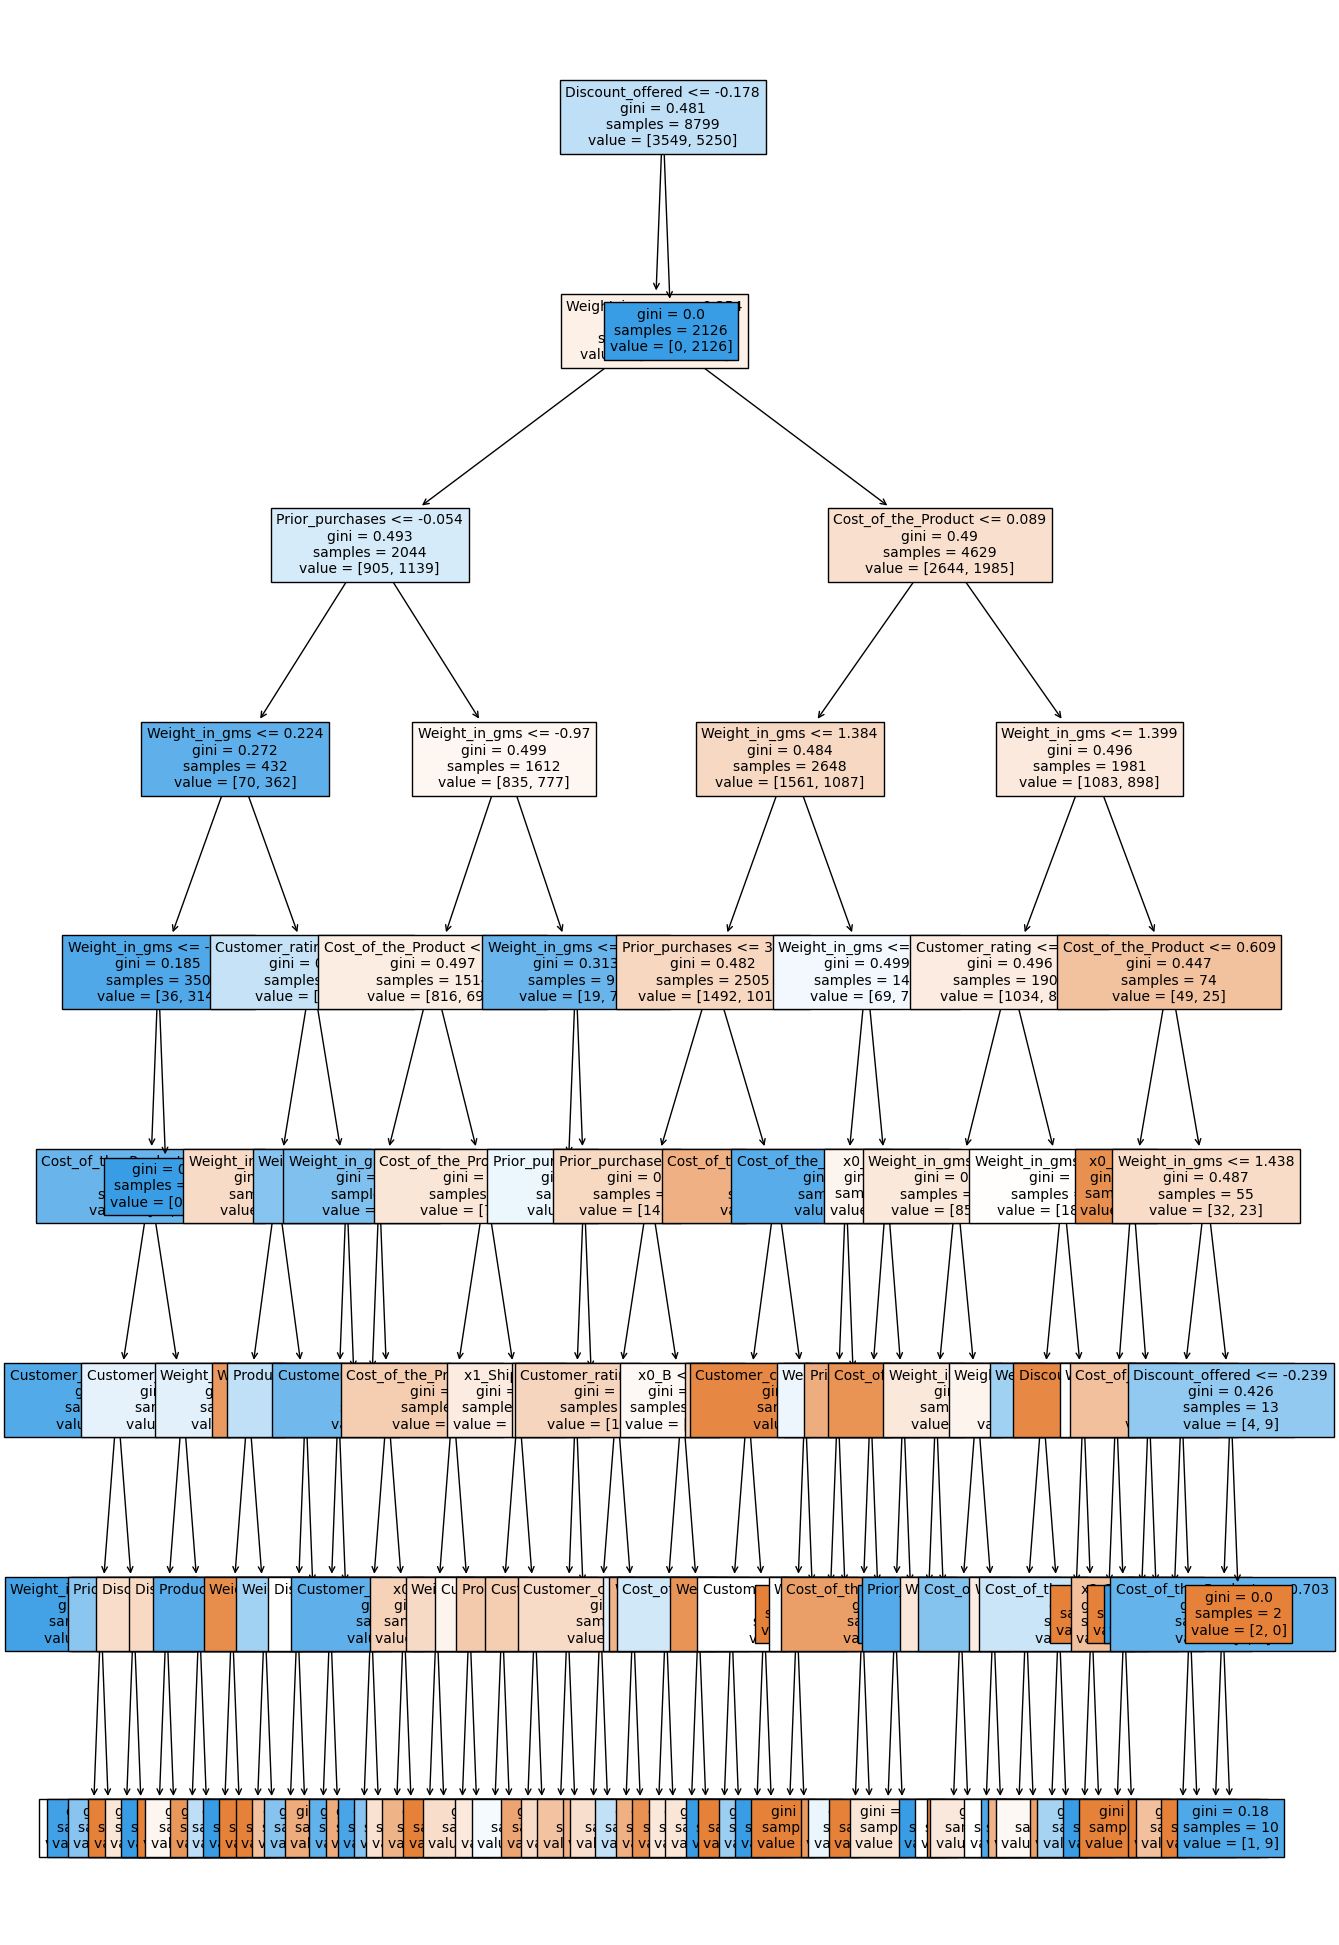

In [24]:
dtc_depth = DecisionTreeClassifier(max_depth=8, random_state=42)
pipe_depth = make_pipeline(preprocess, GridSearchCV(dtc_depth,
                                      param_grid = {},
                                      return_train_score=True))
pipe_depth.fit(X_dev, y_dev)
grid_search_results = pipe_depth.named_steps['gridsearchcv']
best_tree = grid_search_results.best_estimator_
plt.figure(figsize=(15,25))
draw_tree = plot_tree(best_tree, feature_names=feature_names, fontsize=10, filled=True)
plt.show()

**1.9: Prune the tree using one of the techniques discussed in class and evaluate the performance.**

**Print the optimal value of the tuned parameter.**

Best train score:  0.6875789446483023
Best train alpha:  {'ccp_alpha': 0.001}
Test score: 0.6777272727272727


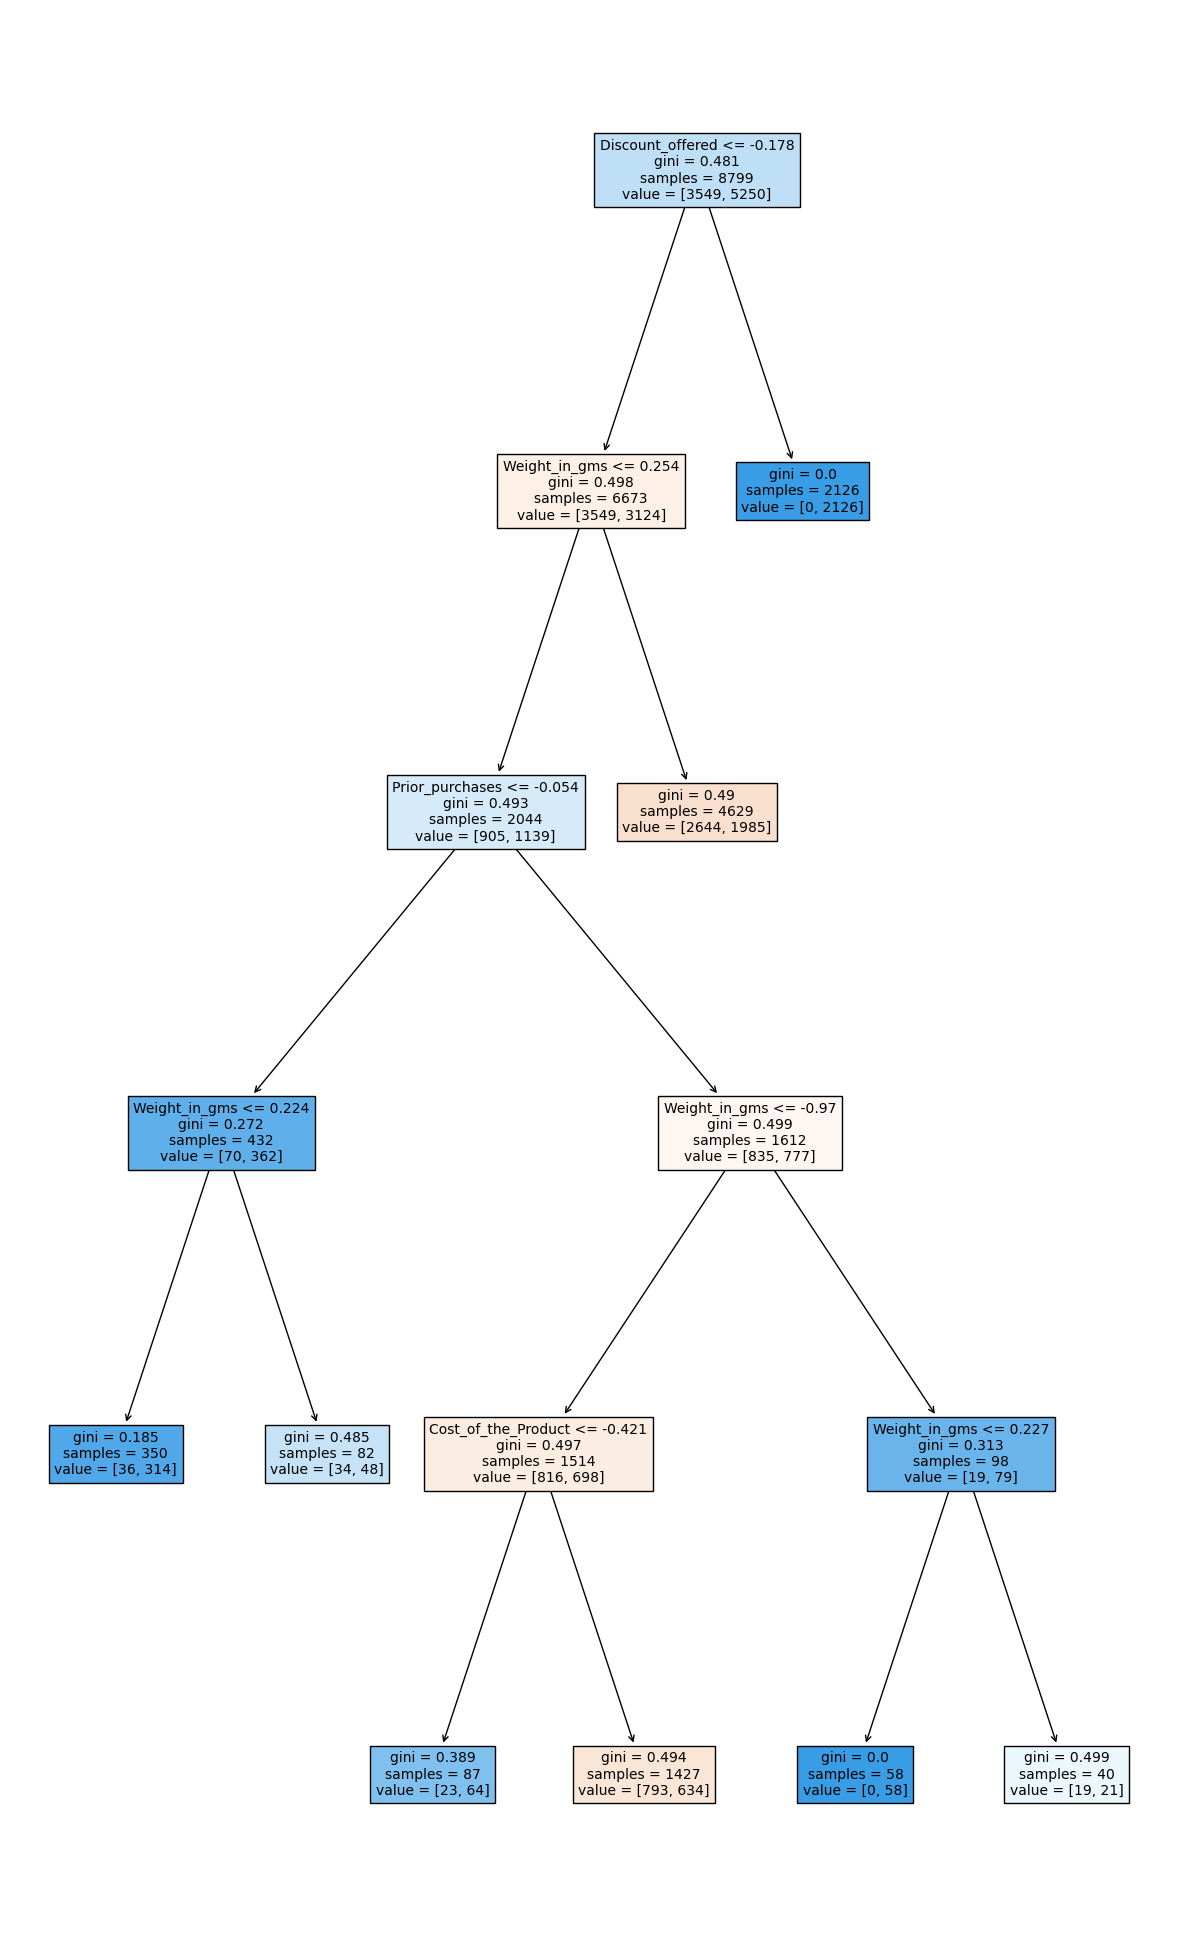

In [25]:
## YOUR CODE HERE
clf = DecisionTreeClassifier(random_state=81)
param_grid = {'ccp_alpha': [0.0, 0.001, 0.002, 0.003, 0.004, 0.005]}
pipe = make_pipeline(preprocess, GridSearchCV(clf,
                                             param_grid = param_grid,
                                             return_train_score=True))
pipe.fit(X_dev, y_dev)
grid_search_results = pipe.named_steps['gridsearchcv']
print(f"Best train score: ", grid_search_results.best_score_) 
print(f"Best train alpha: ", grid_search_results.best_params_) 
print(f"Test score:", pipe.score(X_test, y_test))
best_tree = grid_search_results.best_estimator_
plt.figure(figsize=(15,25))
draw_tree = plot_tree(best_tree, feature_names=feature_names, fontsize=10, filled=True)
plt.show()

**1.10: List the top 3 most important features for this trained tree? How would you justify these features being the most important?**

In [27]:
## YOUR CODE HERE
importance = best_tree.feature_importances_
indices = importance.argsort()[::-1]
top_3 = indices[:3]
print("Top 3 most important features:")
for i in top_3:
    print(f"{feature_names[i]}: {importance[i]}")

Top 3 most important features:
Discount_offered: 0.8256982312232757
Weight_in_gms: 0.08354561588902093
Prior_purchases: 0.07815447267370194


/Users/jasonjin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


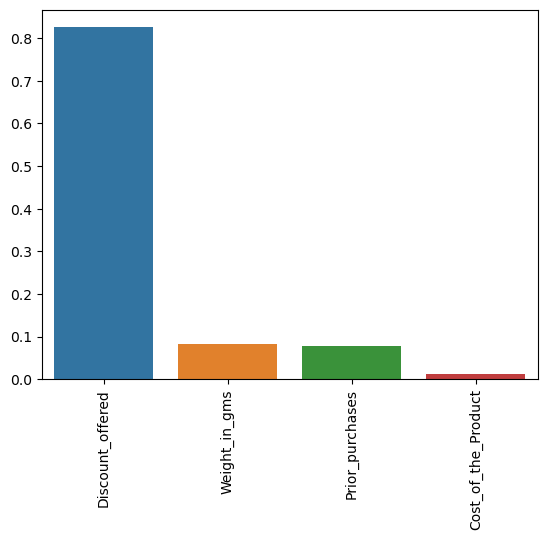

In [28]:
feat_imps = zip(feature_names, best_tree.feature_importances_)
feats, imps = zip(*(sorted(list(filter(lambda x: x[1] != 0, feat_imps)), key=lambda x:x[1], reverse=True)))
ax = sns.barplot(list(feats), list(imps))
ax.tick_params(axis='x', rotation=90)

## Question 2: Random Forests

**2.1: Train a Random Forest model on the development dataset using RandomForestClassifier class in sklearn. Use the default parameters. Evaluate the performance of the model on test dataset. Use accuracy and F1 score to evaluate. Does this perform better than Decision Tree on the test dataset (compare to results in Q 1.7)?**

In [29]:
## YOUR CODE HERE
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=0)
param_grid = {}
pipe = make_pipeline(preprocess, GridSearchCV(rfc,
                                             param_grid = param_grid,
                                             return_train_score=True))
pipe.fit(X_dev, y_dev)
grid_search_results = pipe.named_steps['gridsearchcv']
print(f"Best train score: ", grid_search_results.best_score_) 
print(f"Best train alpha: ", grid_search_results.best_params_) 
print(f"Test score:", pipe.score(X_test, y_test))

Best train score:  0.6573492170137991
Best train alpha:  {}
Test score: 0.6581818181818182


In [32]:
y_pred = pipe.predict(X_test)
print(f"Test accuracy: ", accuracy_score(y_test, y_pred))
print(f"Test f-1 score: ", f1_score(y_test, y_pred))

Test accuracy:  0.6581818181818182
Test f-1 score:  0.6832350463352991


Yes the model performs slightly better than Decision Tree model

**2.2: Do all trees in the trained random forest model have pure leaves? How would you verify that all trees have pure leaves? Print the score (mean accuracy) values of your choosen method**

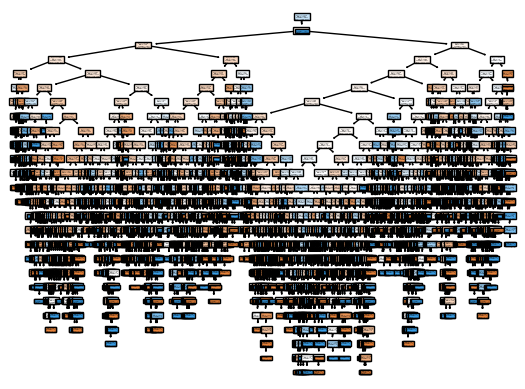

In [33]:
## YOUR CODE HERE
draw_tree = plot_tree(grid_search_results.best_estimator_.estimators_[0], filled=True)
plt.show()

While it may require some additional time and effort to fully draw out the tree, it is ultimately the most reliable method for verifying the values at the terminal nodes and ensuring that all leaves are pure.

**2.3: Assume you want to improve the performance of this model. Also, assume that you had to pick two hyperparameters that you could tune to improve its performance. Which hyperparameters would you choose and why?**


## YOUR SOLUTION HERE
n_estimators to help with the model's variance and improve its accuracy and max_depth to find the right balance between bias and variance.

**2.4: Now, assume you had to choose up to 5 different values (each) for these two hyperparameters. How would you choose these values that could potentially give you a performance lift?**

In [36]:
## YOUR SOLUTION HERE
rfc = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators':[100, 200, 400, 800, 1600],
    'max_depth':[10, 20, 30, 40, 50]
}
pipe = make_pipeline(preprocess, GridSearchCV(rfc,
                                             param_grid = param_grid,
                                             return_train_score=True,
                                             n_jobs=-1))
pipe.fit(X_dev, y_dev)
grid_search_results = pipe.named_steps['gridsearchcv']
print(f"Best train score: ", grid_search_results.best_score_)
print(f"Best train alpha: ", grid_search_results.best_params_)
print(f"Test score: ", pipe.score(X_test,y_test))


Best train score:  0.6735996046307303
Best train alpha:  {'max_depth': 10, 'n_estimators': 800}
Test score:  0.6740909090909091


**2.5: Perform model selection using the chosen values for the hyperparameters. Use out-of-bag (OOB) error for finding the optimal hyperparameters. Report on the optimal hyperparameters. Estimate the performance of the optimal model (model trained with optimal hyperparameters) on train and test dataset? Has the performance improved over your plain-vanilla random forest model trained in Q2.1?**

In [43]:
## YOUR CODE HERE
rfc = RandomForestClassifier(random_state=42, oob_score=True)
param_grid = {
    'n_estimators':[800],
    'max_depth':[10]
}
pipe = make_pipeline(preprocess, GridSearchCV(rfc,
                                             param_grid = param_grid,
                                             return_train_score=True,
                                             n_jobs=-1))
pipe.fit(X_dev, y_dev)
grid_search_results = pipe.named_steps['gridsearchcv']
print(f"Best train score: ", grid_search_results.best_score_)
print(f"Best train alpha: ", grid_search_results.best_params_)
print(f"OOB score: ", grid_search_results.best_estimator_.oob_score_)
print(f"Test score: ", pipe.score(X_test,y_test))

Best train score:  0.6735996046307303
Best train alpha:  {'max_depth': 10, 'n_estimators': 800}
OOB score:  0.6783725423343562
Test score:  0.6740909090909091


 **2.6: Can you find the top 3 most important features from the model trained in Q2.5? How do these features compare to the important features that you found from Q1.10? If they differ, which feature set makes more sense?**

In [44]:
## YOUR CODE HERE
best_trees = grid_search_results.best_estimator_
importance = best_trees.feature_importances_
indices = importance.argsort()[::-1]
top_3 = indices[:3]
print("Top 3 most important features:")
for i in top_3:
    print(f"{feature_names[i]}: {importance[i]}")

Top 3 most important features:
Discount_offered: 0.3729356201082552
Weight_in_gms: 0.32210718273031186
Cost_of_the_Product: 0.0994972425536031


/Users/jasonjin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


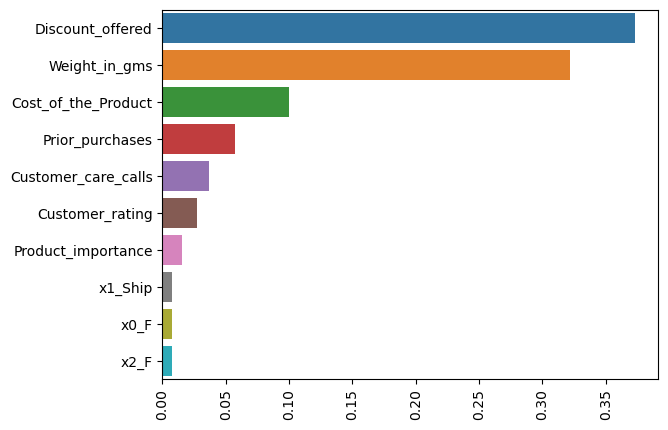

In [47]:
rf = grid_search_results.best_estimator_
feat_imps = zip(feature_names, rf.feature_importances_)
feats, imps = zip(*(sorted(list(filter(lambda x: x[1] != 0, feat_imps)), key=lambda x:x[1], reverse=True)))
ax = sns.barplot(list(imps[:10]), list(feats[:10]))
ax.tick_params(axis='x', rotation=90)

## Question 3: Gradient Boosted Trees

**3.1: Choose three hyperparameters to tune HistGradientBoostingClassifier on the development dataset using 5-fold cross validation. For each hyperparmeter, give it 3 potential values. Report on the time taken to do model selection for the model. Also, report the performance of the test dataset from the optimal models.**

In [48]:
## YOUR CODE HERE
from sklearn.ensemble import HistGradientBoostingClassifier

param_grid = {
    'max_depth':[3,5,7],
    'learning_rate':[0.1, 0.01, 0.001],
    'min_samples_leaf':[1,2,4]
}

hbgc = HistGradientBoostingClassifier()
pipe = make_pipeline(preprocess, GridSearchCV(hbgc,
                                             param_grid=param_grid,
                                             return_train_score=True,
                                             cv=5,
                                             ))
pipe.fit(X_dev, y_dev)
grid_search_results = pipe.named_steps['gridsearchcv']
print(f"Best train score: ", grid_search_results.best_score_)
print(f"Best train alpha: ", grid_search_results.best_params_)
print(f"Test Score: ", pipe.score(X_test, y_test))


Best train score:  0.6792825210605199
Best train alpha:  {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2}
Test Score:  0.6754545454545454


**3.2: Repeat 3.1 for XGBoost.**

**Note**: For XGBoost, you **DO NOT NEED** to choose the same hyperparameters as HistGradientBoostingClassifier.

In [29]:
#pip install xgboost

In [49]:
## YOUR CODE HERE
from xgboost import XGBClassifier
pipe = make_pipeline(
    preprocess,
    GridSearchCV(
        XGBClassifier(random_state=42),
        param_grid={
            'max_depth': [3, 5, 7, 9],
            'learning_rate': [0.1, 0.01, 0.001, 0.0001],
            'n_estimators': [50, 100, 200],
            'gamma': [0, 0.1, 0.2]
        },
        cv=5,
        return_train_score=True
    )
)
# Fit the pipeline on the development dataset
pipe.fit(X_dev, y_dev)
# Get the grid search results
grid_search_results = pipe.named_steps['gridsearchcv']
# Print the optimal hyperparameters
print('Optimal hyperparameters:', grid_search_results.best_params_)
# Print the time taken to do model selection
print('Time taken:', grid_search_results.refit_time_)
# Evaluate the performance of the pipeline on the test dataset
test_score = pipe.score(X_test, y_test)
print('Test score:', test_score)

Optimal hyperparameters: {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Time taken: 0.14075922966003418
Test score: 0.6772727272727272


**3.3: Compare the results on the test dataset of XGBoost and HistGradientBoostingClassifier. Which model do you prefer and why?**

## YOUR CODE HERE
The XGBoost model has achieved a higher test score than the HistGradientBoostingClassifier model, which suggests that it may have better predictive accuracy on new data. Additionally, XGBoost is known for its scalability, which can result in faster performance of the boosting algorithm when dealing with large datasets.

**3.4: Can you list the top 3 important features from the trained XGBoost model? How do they differ from the features found from Random Forest and Decision Tree?**

In [50]:
## YOUR CODE HERE
best_trees_xbg = grid_search_results.best_estimator_
importance = best_trees_xbg.feature_importances_
indices = importance.argsort()[::-1]
top_3 = indices[:3]
print("Top 3 most important features:")
for i in top_3:
    print(f"{feature_names[i]}: {importance[i]}")

Top 3 most important features:
Discount_offered: 0.8135257959365845
Prior_purchases: 0.11220099031925201
Weight_in_gms: 0.048295456916093826


/Users/jasonjin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


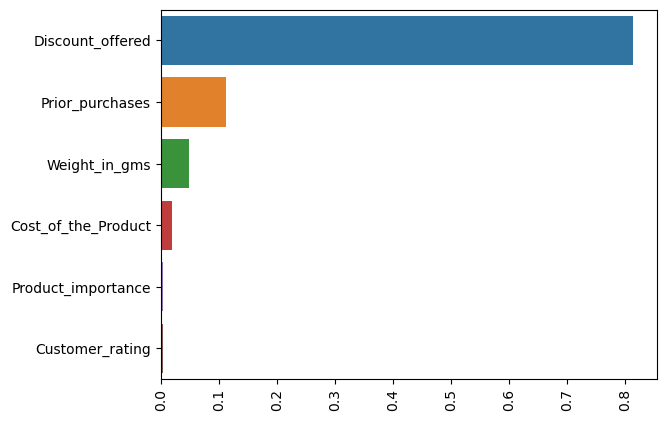

In [51]:
feat_imps = zip(feature_names, best_trees_xbg.feature_importances_)
feats, imps = zip(*(sorted(list(filter(lambda x: x[1] != 0, feat_imps)), key=lambda x:x[1], reverse=True)))
ax = sns.barplot(list(imps[:10]), list(feats[:10]))
ax.tick_params(axis='x', rotation=90)

The top 3 important features from the trained models are the following:

XGBoost:
Discount_offered, Prior_purchases, Weight_in_gms

Random Forest:
Discount_offered, Weight_in_gms, Cost_of_the_Product

Decision Tree:
Discount_offered, Weight_in_gms, Prior_purchases

**3.5: Can you choose the top 5 features (as given by feature importances from XGBoost) and repeat Q3.2? Does this model perform better than the one trained in Q3.2? Why or why not is the performance better?**

In [52]:
## YOUR CODE HERE
best_trees_xbg = grid_search_results.best_estimator_
importance = best_trees_xbg.feature_importances_
indices = importance.argsort()[::-1]
top_5 = indices[:5]
for i in top_5:
    print(f"{feature_names[i]}")

Discount_offered
Prior_purchases
Weight_in_gms
Cost_of_the_Product
Product_importance


In [53]:
te_features_top = ['Product_importance']
num_features_top = ['Discount_offered', 'Prior_purchases', 'Weight_in_gms', 'Cost_of_the_Product']
preprocess = make_column_transformer(
    (StandardScaler(), num_features_top),
    (TargetEncoder(handle_unknown='ignore'), te_features_top)
)

In [54]:
pipe = make_pipeline(
    preprocess,
    GridSearchCV(
        XGBClassifier(random_state=42),
        param_grid={
            'max_depth': [3, 5, 7, 9],
            'learning_rate': [0.1, 0.01, 0.001, 0.0001],
            'n_estimators': [50, 100, 200],
            'gamma': [0, 0.1, 0.2]
        },
        cv=5,
        return_train_score=True
    )
)
# Fit the pipeline on the development dataset
pipe.fit(X_dev, y_dev)
# Get the grid search results
grid_search_results = pipe.named_steps['gridsearchcv']
# Print the optimal hyperparameters
print('Optimal hyperparameters:', grid_search_results.best_params_)
# Print the time taken to do model selection
print('Time taken:', grid_search_results.refit_time_)
# Evaluate the performance of the pipeline on the test dataset
test_score = pipe.score(X_test, y_test)
print('Test score:', test_score)

Optimal hyperparameters: {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Time taken: 0.11275982856750488
Test score: 0.6772727272727272


## Question 4: Calibration

**4.1: Estimate the brier score for the HistGradientBoosting model (trained with optimal hyperparameters from Q3.1) scored on the test dataset.**

In [55]:
## YOUR CODE HERE
from sklearn.metrics import brier_score_loss
param_grid = {
    'max_depth':[3],
    'learning_rate':[0.1],
    'min_samples_leaf':[2]
}
hbgc = HistGradientBoostingClassifier()
pipe = make_pipeline(preprocess, GridSearchCV(hbgc,
                                             param_grid=param_grid,
                                             return_train_score=True,
                                             cv=5,
                                             ))
pipe.fit(X_dev, y_dev)
grid_search_results = pipe.named_steps['gridsearchcv']
y_pred = pipe.predict(X_test)
print(f"Brier score: ", brier_score_loss(y_test, y_pred))

Brier score:  0.32227272727272727


**4.2: Calibrate the trained HistGradientBoosting model using Platt Scaling. Print the brier score after calibration and plot predicted v.s. actual on test datasets from the calibration method.**

After calibration, Brier score: 0.325


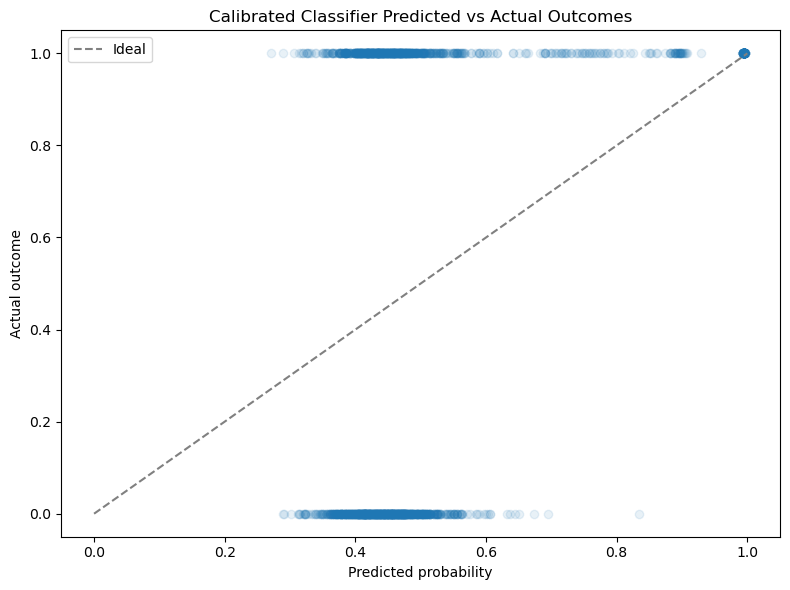

In [57]:
## YOUR CODE HERE
from sklearn.calibration import CalibratedClassifierCV

# calibrate the model using Platt Scaling
platt_scaled_hbgc = CalibratedClassifierCV(hbgc, method='sigmoid', cv=5)
platt_pipe = make_pipeline(preprocess, platt_scaled_hbgc)
platt_pipe.fit(X_dev, y_dev)

# make predictions on the test data after calibration
platt_y_pred = platt_pipe.predict(X_test)

# calculate the Brier score after calibration
print(f"After calibration, Brier score: {brier_score_loss(y_test, platt_y_pred)}")

# plot predicted v.s. actual on test datasets from the calibration method
plt.figure(figsize=(8, 6))
plt.scatter(platt_pipe.predict_proba(X_test)[:,1], y_test, alpha=0.1)
plt.xlabel("Predicted probability")
plt.ylabel("Actual outcome")
plt.title("Calibrated Classifier Predicted vs Actual Outcomes")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Ideal')
plt.legend()
plt.tight_layout()
plt.show()

**4.3: Compare the brier scores from 4.1 and 4.2. Do the calibration methods help in having better predicted probabilities?**

## YOUR CODE HERE
The improvement in Brier score is indicative of a reduction in the mean squared difference between the predicted probabilities and the observed outcomes. This means that the predicted probabilities have become more accurate, and the calibration methods have reduced the gap between the predicted probabilities and the actual outcomes. So brier score obtained in 4.2 using platt scaling suggests that the calibration method was particularly effective.